In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import sys
from iminuit import Minuit
from matplotlib.colors import ListedColormap
from scipy.stats import norm

from tqdm import tqdm
from scipy.integrate import quad
from scipy.stats import chi2
from functools import partial
# 6.2sec

In [3]:
sys.path.append('../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH, simpson38
from ExternalFunctions import nice_string_output, add_text_to_ax 

In [4]:
COLOUR = ['#1E90FF', # 0 # Dodgerblue
          '#FFBF00', # 1 # Amber
          '#FF6347', # 2 # Tomato
          '#00A86B', # 3 # Jade
          '#8A2BE2', # 4 # Blueviolet
          '#FF6FFF', # 5 # Ultra Pink
          '#00CCFF', # 6 # Vivid Sky Blue
          '#00ff40', # 7 # Erin
          '#FF004F', # 8 # Folly
          '#0063A6', # 9 # Lapis Lazuli
        ]
def setMplParam(classNum):
    # Define effective colors, line styles, and markers based on the class number
   
    LINE = ['-', '-.', '--', '-.', ':','--','-.','-', ':', '--']
    MARKER = ['.','*', '^', 's', '.', 'p', 'o', 's', '.', 'd']
    COLOUR_EFF = COLOUR[:classNum]
    LINE_EFF = LINE[:classNum]
    MARKER_EFF = MARKER[:classNum]

    # Set the color cycle for lines including color, line style, and marker
    plt.rcParams['axes.prop_cycle'] = (plt.cycler(color=COLOUR_EFF) +
                                       plt.cycler(linestyle=LINE_EFF)+
                                       plt.cycler(marker=MARKER_EFF))

    # Set default line and marker sizes
    plt.rcParams['lines.markersize'] = 3  # Example size
    plt.rcParams['lines.linewidth'] = 2   # Example width for lines

    # Set label and title sizes
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['axes.titlesize'] = 20

    # Set tick properties
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['ytick.labelsize'] = 20

    # Set legend font size
    plt.rcParams['legend.fontsize'] = 12

    # Enable and configure grid
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.8
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.linewidth'] = 1

    # Set axes line width
    plt.rcParams['axes.linewidth'] = 2

    # Set tick sizes and widths
    plt.rcParams['xtick.major.size'] = 7
    plt.rcParams['xtick.major.width'] = 3
    plt.rcParams['xtick.minor.size'] = 2
    plt.rcParams['xtick.minor.width'] = 2

    plt.rcParams['ytick.major.size'] = 7
    plt.rcParams['ytick.major.width'] = 3
    plt.rcParams['ytick.minor.size'] = 2
    plt.rcParams['ytick.minor.width'] = 2

setMplParam(10)


In [5]:
def ExpDecay(b):
    return lambda x: np.where(x < 0, 0, 1/b * np.exp(-x / b))
# print(ExpDecay(b=1)(0.75))

In [6]:
def Gaussian(mu, sigma):
    return lambda x: 1/np.sqrt(2*np.pi*sigma**2) * np.exp(-(x - mu)**2 / (2*sigma**2))
# print(Gaussian(mu=0, sigma=1)(0.75))

In [7]:
def convExpGauss(b, sigma):
    LOWER_BOUND = 0
    UPPER_BOUND = 100
    mu = 0
    Gaussian_f = Gaussian(mu, sigma)
    ExpDecay_f = ExpDecay(b)
    return np.vectorize(lambda t: quad(lambda t_prime: ExpDecay_f(t_prime) * Gaussian_f(t - t_prime), LOWER_BOUND, UPPER_BOUND)[0])

print(convExpGauss(1,1)(0.75))

0.3125278277997403


In [8]:
def getArea(f, x):
    # REPRODUCIBILITY!
    np.random.seed(75)

    # consistently use this energy range 
    x_min = x.min()
    x_max = x.max()

    y = np.array([f(x_i) for x_i in x])
    y_min = 1e-10
    y_max = y.max()
    N = 10_000
    x_random = np.random.uniform(x_min, x_max, N)
    y_random = np.random.uniform(y_min, y_max, N)
    y_random = y_random[y_random < np.array([f(x_i) for x_i in x_random])]
    accepted = len(y_random)
    area = (x_max - x_min) * (y_max - y_min) * accepted / N
    return area

In [28]:
def plotPDFs():
    b = 1.0
    sigma = 0.5
    mu = 0.0
    x = np.linspace(-5, 5, 100)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(x, Gaussian(mu, sigma)(x), label='Gaussian')
    ax.plot(x, ExpDecay(b)(x), label='Exponential Decay')
    ax.plot(x, convExpGauss(b = b, sigma = sigma)(x), label='Convolution')
    ax.set_xlabel('time(sec)')
    ax.set_ylabel('Probability Density')
    ax.set_title(f'PDFs, $b = {b}$ & $\sigma = {sigma}$')
    ax.legend()
    
    # normalisation check
    area_Gaussian = getArea(Gaussian(mu,sigma), x)
    area_ExpDecay = getArea(ExpDecay(b), x)
    area_convExpGauss = getArea(convExpGauss(1,1), x)
    print(f'Area of Gaussian: {area_Gaussian:.4f}')
    print(f'Area of Exponential Decay: {area_ExpDecay:.4f}')
    print(f'Area of Convolution: {area_convExpGauss:.4f}')

    d = {'Normalisation': '',
         'Gaussian': f'{area_Gaussian:.4f}',
         'Exponential Decay': f'{area_ExpDecay:.4f}',
         'Convolution': f'{area_convExpGauss:.4f}',
        }
    add_text_to_ax(0.05, 0.75, nice_string_output(d), ax, fontsize=12)
    
# plotPDFs()
# > 54 sec
# > 1min 4sec

* data reading part

In [11]:
def readData():
    path = ''
    fileName = 'nuc.data'
    data = pd.read_csv(path + fileName, header = None)
    return data
data_chunk = readData()
print(data_chunk[:3])

          0
0  0.435548
1  1.954933
2  1.613609


In [12]:
def sliceData(data):
    INTERVAL = 200
    for i in range(0, len(data), INTERVAL):
        yield np.array(data.iloc[i:i+INTERVAL, 0])
data = list(sliceData(data_chunk))

print(len(data))
print(data[0].shape)
print(data[99].shape)
print(data[0][:5])
print(data[99][:5])

100
(200,)
(200,)
[0.435548 1.954933 1.613609 0.749512 0.909321]
[2.287424 1.511342 1.258125 0.402836 0.173331]


In [13]:
def LLH_core(f, data):
    return -np.sum(np.log(f(data)))

In [14]:
def fLLH_null(data, sigma):
    f = convExpGauss(1, sigma)
    return LLH_core(f, data)

In [15]:
def fLLH_alt(data, sigma, b):
    f = convExpGauss(b, sigma)
    return LLH_core(f, data)

In [16]:
def rasterScan_sigma(data):
    sig_min = 0.5
    sig_max = 0.7

    steps = 20
    
    sig_values = np.linspace(sig_min, sig_max, steps)
    LLH_values = np.zeros(steps)
    for i, sig in enumerate((sig_values)):
        LLH_values[i] = fLLH_null(data, sig)
    min_index = np.argmin(LLH_values)
    min_LLH = LLH_values[min_index]
    return min_LLH, sig_values[min_index]

In [17]:
def rasterScan_b_sigma(data):
    sig_min = 0.5
    sig_max = 0.7
    b_min = 0.5
    b_max = 1.5
    
    steps = 20
    
    b_values = np.linspace(b_min, b_max, steps)
    sig_values = np.linspace(sig_min, sig_max, steps)
    LLH_values = np.zeros((steps, steps))
    for i, b in enumerate((b_values)):
        for j, sig in enumerate(sig_values):
            LLH_values[i, j] = fLLH_alt(data, sig, b)
    min_index = np.unravel_index(np.argmin(LLH_values, axis=None), LLH_values.shape)
    min_LLH = LLH_values[min_index]
    return min_LLH, b_values[min_index[0]], sig_values[min_index[1]]


In [18]:
def rasterNull(data):
    minLLHs = np.zeros(len(data))
    sigmas = np.zeros(len(data))
    for i, d in enumerate(tqdm(data)):
        minLLHs[i], sigmas[i] = rasterScan_sigma(d)
    return minLLHs, sigmas

In [19]:
def rasterAlt(data):
    minLLHs = np.zeros(len(data))
    bs = np.zeros(len(data))
    sigmas = np.zeros(len(data))
    for i, d in enumerate(tqdm(data)):
        minLLHs[i], bs[i], sigmas[i] = rasterScan_b_sigma(d)
    return minLLHs, bs, sigmas

* **Temporarily disabled**
* Raster scan for the null hypothesis
* takes < 5 min

In [20]:
# llh_null, sigma_null = rasterNull(data)
# 15sec / data_i 
# 1500 sec = 25min
# win : 6 min 20sec = 380 sec

* **Temporarily disabled**
* Raster scan for the althernative hypothesis
* takes ~ 120 min

In [21]:
# llh_alt, b_alt, sigma_alt = rasterAlt(data)
# 225 sec / data_i = 3min 50sec / data_i
# 22500 sec = 6.25 hours
# win : 2 hours 10 min = 7800 sec

* store the data to `results/[Ex3]RasterScan.txt`

In [22]:
def writeRasterData(llh_null, sigma_null, llh_alt, b_alt, sigma_alt):
    path = 'results/'
    fileName = '[Ex3]RasterScan.txt'
    df = pd.DataFrame({'llh_null': llh_null, 'sigma_null': sigma_null, 'llh_alt': llh_alt, 'b_alt': b_alt, 'sigma_alt': sigma_alt})
    df.to_csv(path + fileName, index=False)
# writeRasterData(llh_null, sigma_null, llh_alt, b_alt, sigma_alt)

* read data from `results/[Ex3]RasterScan.txt`

In [23]:
def readRasterData():
    path = 'results/'
    fileName = '[Ex3]RasterScan_120324.txt'
    data = pd.read_csv(path + fileName)
    print(data.head())

    return data
data = readRasterData()

     llh_null  sigma_null     llh_alt     b_alt  sigma_alt
0  290.675339    0.584211  290.666010  1.026316   0.584211
1  307.161342    0.636842  307.174905  0.973684   0.636842
2  271.006033    0.521053  270.220060  0.921053   0.521053
3  303.945772    0.636842  303.743696  1.078947   0.626316
4  304.108446    0.563158  302.325058  1.131579   0.542105


In [25]:
def displayParamStats(data):
    mean_sigma_null = data['sigma_null'].mean()
    median_sigma_null = data['sigma_null'].median()
    std_sigma_null = data['sigma_null'].std()

    mean_sigma_alt = data['sigma_alt'].mean()
    median_sigma_alt = data['sigma_alt'].median()
    std_sigma_alt = data['sigma_alt'].std()
    
    mean_b_alt = data['b_alt'].mean()
    median_b_alt = data['b_alt'].median()
    std_b_alt = data['b_alt'].std()
    
    print('mean, median, std dev')
    print(f'sigma_null: {mean_sigma_null:.4f}, {median_sigma_null:.4f}, {std_sigma_null:.4f}')
    print(f'sigma_alt: {mean_sigma_alt:.4f}, {median_sigma_alt:.4f}, {std_sigma_alt:.4f}')
    print(f'b_alt: {mean_b_alt:.4f}, {median_b_alt:.4f}, {std_b_alt:.4f}')
displayParamStats(data)

mean, median, std dev
sigma_null: 0.6136, 0.6263, 0.0555
sigma_alt: 0.6123, 0.6263, 0.0576
b_alt: 0.9953, 0.9737, 0.0901


In [ ]:
def getLlhRatio(llh_null, llh_alt):
    return 2 * (llh_null - llh_alt)

In [ ]:
def getHistoParam(data, isNormalized = False):
    Nbins = int(np.sqrt(data.shape[0]*4))
    counts, x_edges = np.histogram(data, bins=Nbins, density=isNormalized)
    binwidth = x_edges[1] - x_edges[0]
    x_centres = x_edges[:-1] + binwidth/2
    return Nbins, binwidth, counts, x_centres

In [ ]:
def getNAboveCut(data, dof, cut):
    above = data[data > cut]
    x = dof * np.sqrt(cut)
    cdf_left = norm.cdf(x, loc = 0.0, scale = dof)
    cdf_right = norm.cdf(-x, loc = 0.0, scale = dof)
    within_x = cdf_left - cdf_right
    p_above = 1 - within_x

    return len(above), p_above

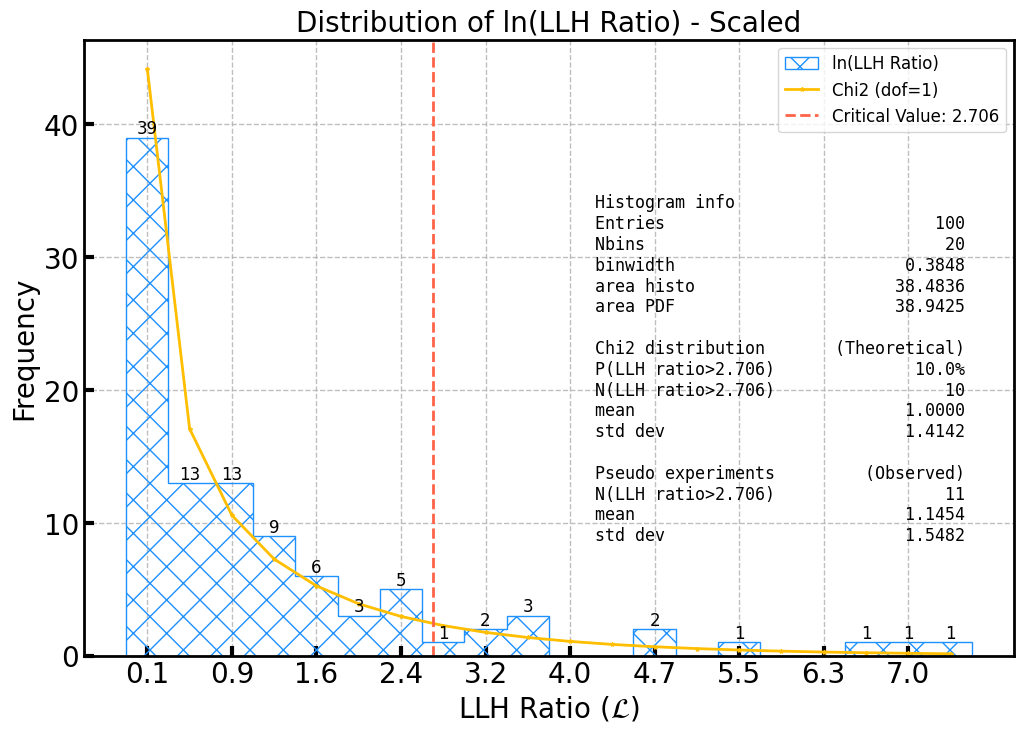

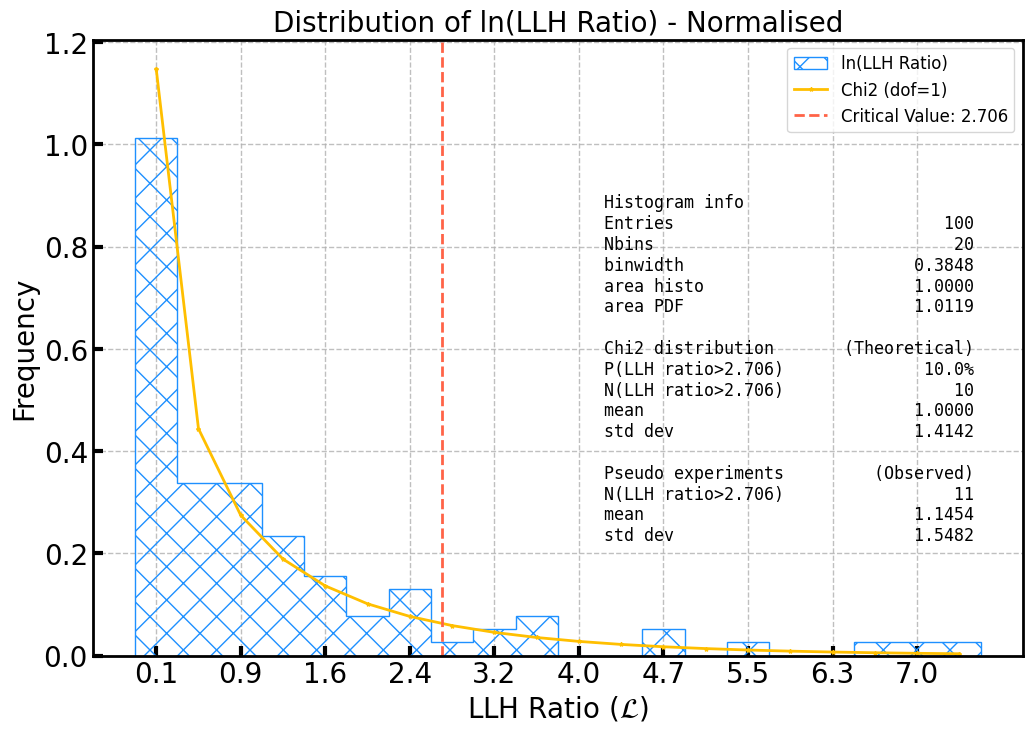

In [ ]:
def plotHistLlhRatio(llh_null, llh_alt, isNormalized=False):
    llh_ratio = getLlhRatio(llh_null, llh_alt)
    Nbins, binwidth, counts, x_centres = getHistoParam(llh_ratio, isNormalized)
    bins = np.arange(x_centres[0] - 0.5 * binwidth, x_centres[-1] + 1.5 * binwidth, binwidth)
    Ndata = len(llh_ratio)

    factor = 1.0
    if not isNormalized:
        factor = Ndata * binwidth
    dof = 1
    y_chi2 = chi2.pdf(x_centres, df=dof) * factor
    
    # critical
    cutRatio = 2.706
    N_above, p_above = getNAboveCut(llh_ratio, dof, cutRatio)

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.hist(llh_ratio, bins=bins, histtype='step', hatch='\\/', label='ln(LLH Ratio)', density=isNormalized)
    ax.plot(x_centres, y_chi2, linestyle='-', label=f'Chi2 (dof={dof})')
    ax.axvline(cutRatio, color = COLOUR[2], linestyle='--', label=f'Critical Value: {cutRatio:.3f}')

    ax.set_xlabel(r'LLH Ratio ($\mathcal{L}$)')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of ln(LLH Ratio){" - Normalised" if isNormalized else " - Scaled"}')

    ax.set_xticks(x_centres[::2])
    ax.set_xticklabels([f'{float(label):.1f}' for label in x_centres[::2]])
    ax.legend()

    ax.legend()

    if not isNormalized:
        for x, count in zip(x_centres, counts):
            if count > 0:
                ax.text(x, count, f'{count:.0f}', ha='center', va='bottom', fontsize=12)
    
    area_histo = np.sum(counts) * binwidth
    area_pdf = np.sum(y_chi2) * (bins[1] - bins[0])
    d = {
    'Histogram info': '',
    'Entries': f'{Ndata}',
    'Nbins': f'{Nbins}',
    'binwidth': f'{binwidth:.4f}',
    'area histo': f'{area_histo:.4f}',
    'area PDF': f'{area_pdf:.4f}',
    '':'',
    'Chi2 distribution': '(Theoretical)',
    f'P(LLH ratio>{cutRatio})': f'{p_above:.1%}',
    f'N(LLH ratio>{cutRatio})': f'{Ndata*p_above:.0f}',
    f'mean': f'{dof:.4f}',
    f'std dev': f'{np.sqrt(2*dof):.4f}',
    ' ':' ',
    'Pseudo experiments': '(Observed)',
    f'N(LLH ratio>{cutRatio}) ': f'{N_above:d}',
    'mean ': f'{np.mean(llh_ratio):.4f}',
    'std dev ': f'{np.std(llh_ratio):.4f}',
    }
    add_text_to_ax(0.55, 0.75, nice_string_output(d), ax, fontsize=12)

plotHistLlhRatio(data['llh_null'], data['llh_alt'])
plotHistLlhRatio(data['llh_null'], data['llh_alt'], True)

* **Failed trial using minuit**

In [ ]:
# def LLHRatioCore(data, b, sigma):
#     _lnLLH_null = fLLH_null(data, sigma)  # -ln
#     _lnLLH_alt = fLLH_alt(data, sigma, b)  # -ln
#     print(f'LLH_null: {_lnLLH_null:.4f}')
#     print(f'LLH_alt: {_lnLLH_alt:.4f}')
#     return -2 * (_lnLLH_null - _lnLLH_alt)

In [ ]:
# def getMinLLH_null(data):
#     sigma0 = 0.6
#     f = partial(fLLH_null, data)
#     minuit = Minuit(f, sigma = sigma0)

#     minuit.limits['sigma'] = (0.5, 0.7)
#     minuit.errors['sigma'] = 0.01
#     minuit.migrad()
#     return minuit

In [ ]:
# def getMinLLH_alt(data):
#     b0 = 1.0
#     sigma0 = 0.6
#     f = partial(fLLH_alt, data)
#     minuit = Minuit(f, b = b0, sigma = sigma0)
    
#     minuit.limits['b'] = (0.0, 10)
#     minuit.limits['sigma'] = (0.0, 10)
#     minuit.errors['sigma'] = 0.1
#     minuit.errors['b'] = 0.1
#     minuit.migrad()
#     return minuit

In [ ]:
# def LLHRatioInterface(data):
#     minuit_null = getMinLLH_null(data)
#     sigma = minuit_null.values['sigma']
#     minuit_alt = getMinLLH_alt(data)
#     sigma = minuit_alt.values['sigma']
#     b = minuit_alt.values['b']
#     Lambda = LLHRatioCore(data, b, sigma)
#     return Lambda

# # 45 sec
# # 1 min 57sec

In [ ]:
# def minimiseBatch(data):
#     N = len(data)
#     Lambdas = np.zeros(N)

#     for i, data_i in enumerate(tqdm(data)):
#         Lambdas[i] = LLHRatioInterface(data_i)
#     return Lambdas

In [ ]:
# Lambdas = minimiseBatch(data)

# 94 min
# 22 min


In [ ]:
# # def makeResultFile(Lambdas, nullSigmas, altBs, altSigmas):
# #     result = pd.DataFrame({'Lambda': Lambdas,
# #                            'NullSigma': nullSigmas,
# #                            'AltB': altBs,
# #                            'AltSigma': altSigmas})
# #     result.to_csv('results/[Ex2]result.csv', index=False)
# def makeResultFile(Lambdas):
#     result = pd.DataFrame({'Lambda': Lambdas})
#     result.to_csv('results/[Ex2]lambdas.csv', index=False)

In [ ]:
# makeResultFile(Lambdas, nullSigmas, altBs, altSigmas)

In [ ]:
# def loadResultFile():
#     data = pd.read_csv('results/[Ex2]result.txt', dtype=float)
#     data.columns = ['Lambda', 'NullSigma', 'AltB', 'AltSigma']
#     return data

In [ ]:
# results = loadResultFile()